# PWD 2: Automated Vegetation Monitoring using Satellite Images and Artificial Intelligence

![sss](flowchart.drawio.png)

### Warping

The nDSM model from LiDAR might not be completely aligned with the satellite. This is a common problem, hard to solve automatically and is due to bad/different ortho-recitification process. 
Here, I used Photoshop to try to match as well as possible the nDSM and satellite manually.
Use the `warping.py` script to generate a (better) aligned version.

<img src="images/nDSM_unwarped.jpeg" width="400">
<img src="images/nDSM_warped.jpeg" width="400">

### GridEyeS library
Import the `GridEyeS_lib` library, which will be used for the entire framework. The library implements all the sub-tasks (tree segmentation, tree species classification, risk analysis, etc.) that will be used later on. 

In [2]:
import GridEyeS_lib as ges
import matplotlib.pyplot as plt

### Extracting tree mask

We extract a tree mask ground truth of the area, namely $GT_{tree}$. 

$GT_{tree}$ is used: 
- for training and validate the tree segmentation model
- for the tree species classification inside the *TreeSpeciesClassifier* class
- for a better crown delineation, together with the *3DModeler*

$GT_{tree}$ is computed as $GT_{tree} = (nDSM > Th_1) \vee (NDVI > Th_2)$

nDSM comes from the previous step. NDVI is calculates from QGIS (even though Python can be used as well)


In [3]:
# Load nDSM and NDVI
nDSM, meta_data = ges.io.open_geoTiFF("_data/trees/3D_modeling/GT/warping/nDSM_warped.tif")
NDVI = ges.io.open_geoTiFF("_data/NDVI.tif", with_meta_data=False)

# Calculate the tree mask ground truth 
tree_points = ges.geo_utils.generate_tree_points(nDSM, NDVI, Th1 = 2, Th2 = 0.1)
# Export it
ges.io.export_GEOtiff(ges.utils.open_dir("Set <tree_points> saving directory ") + "/GTtree.tif", tree_points, meta_data) 

Tranposing dimensions: 

(1, 9024, 12915)
--> (9024, 12915, 1)
Tranposing dimensions: 

(1, 9023, 12914)
--> (9023, 12914, 1)
Resizing to same shape
Tranposing dimensions: 

(9023, 12914, 1)
--> (1, 9023, 12914)


Plot the tree ground truth:

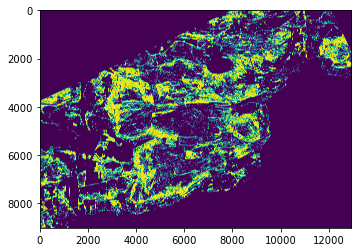

In [4]:
plt.imshow(tree_points)

## Create a tree segmentation map over the area

We use the `<TreeSegmenter>` class to build a deep-learning based tree segmentation model.
The [Tree segmentation](/Block_tree_segmentation.ipynb) Jupyter notebook provides a step-by-step guide on how to perform tree segmentation using *ges*.

## Create a tree segmentation map over the area

We use the `<TreeSpeciesClassifier>` class to build a deep-learning based tree species classifier.
The [Tree species classification](/Block_tree_species_classification.ipynb) Jupyter notebook provides a step-by-step guide on how to perform tree species classification using *ges*.

## Create a 3D nDSM estimator over the area

We use the `<class>` class to build a deep-learning based tree species classifier.
The [TODO]() Jupyter notebook provides a step-by-step guide on how to estimate the NDSM over the area using *ges*.

## SCAN power line

We scan the infrastructure line (here power lines) and extract  a point every 40 meters. 

In [ ]:
power_line = ges.io.load_infrastructure_line("_data/power_lines/Kraftnett_files/power_lines.gpkg")
# Convert to a more suitable CRS
power_line = power_line.to_crs("epsg:32632")

# Scan power line
points_along_line = ges.infrastructure_utils.scan_lines(power_line, distance = 40, save_output = True)

![power line sample](images/power_lines.jpeg)

## Tree inventory generation

In [ ]:
tree_mask = ges.tree_segmentation.binarize_treeMap(tree_mask, thresholds = [128])
tree_mask = ges.tree_segmentation.refine_tree_mask(tree_mask)

radius = 40
crowns = ges.infrastructure_utils.generate_tree_inventory(points_along_line, SAT_map, meta_data, radius, tree_mask)
crowns.to_file("crowns.gpkg", driver="GPKG") 

![Crown delineation](images/crowns.jpeg)